In [12]:
import json
from networkx.readwrite import json_graph
import random
def read_graph_from_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return json_graph.adjacency_graph(data) 

In [13]:
# Read Oklahoma county graph from the json file "OK_county.json"
filepath = 'districting-data/'
filename = 'OK_county.json'

G = read_graph_from_json( filepath + filename )

In [14]:
for node in G.nodes:
    # assign a random workload for each block from 1 to 10
    county_name = G.nodes[node]['NAME20']
    G.nodes[node]['workload'] = random.randint(1,10)
    G.nodes[node]['C_X'] = G.nodes[node]['INTPTLON20']  # longitude of block's center
    G.nodes[node]['C_Y'] = G.nodes[node]['INTPTLAT20']  # latitude of block's center
    print("Node",node,"represents",county_name,"County, which had a workload of",G.nodes[node]['workload'])

Node 0 represents Washita County, which had a workload of 2
Node 1 represents Jackson County, which had a workload of 3
Node 2 represents Major County, which had a workload of 5
Node 3 represents Delaware County, which had a workload of 8
Node 4 represents Custer County, which had a workload of 7
Node 5 represents Ellis County, which had a workload of 7
Node 6 represents Oklahoma County, which had a workload of 2
Node 7 represents Johnston County, which had a workload of 2
Node 8 represents Comanche County, which had a workload of 10
Node 9 represents Pushmataha County, which had a workload of 9
Node 10 represents Cleveland County, which had a workload of 6
Node 11 represents Wagoner County, which had a workload of 9
Node 12 represents Beckham County, which had a workload of 10
Node 13 represents Garvin County, which had a workload of 2
Node 14 represents Craig County, which had a workload of 1
Node 15 represents Cherokee County, which had a workload of 2
Node 16 represents Osage Count

In [15]:
# we are to solve the following task:
# input: a workload vector, desired number of sectors k
# output: a partition of the workloads into k sectors (not necessarily connected!) 
#            to minimize the difference between most and least workload districts

import gurobipy as gp
from gurobipy import GRB

In [16]:
k = 10  # desired number of sectors

# create model 
m = gp.Model()

# create variables
x = m.addVars( G.nodes, k, vtype=GRB.BINARY )  # x[i,j] = 1 when block i is assigned to sector with center block j
y = m.addVar()                                 # y = workload of smallest sector
z = m.addVar()                                 # z = workload of largest sector

In [17]:
# objective is to minimize absolute population deviation
m.setObjective( z - y, GRB.MINIMIZE )

# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in range(k) ) == 1 for i in G.nodes ) 

# add constraints saying that each district has population at least y
m.addConstrs( gp.quicksum( G.nodes[i]['workload'] * x[i,j] for i in G.nodes ) >= y for j in range(k) )

# add constraints saying that each district has population at most z
m.addConstrs( gp.quicksum( G.nodes[i]['workload'] * x[i,j] for i in G.nodes ) <= z for j in range(k) )

m.update()

In [18]:
# solve IP model
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: AMD Ryzen Threadripper 3990X 64-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads

Optimize a model with 97 rows, 772 columns and 2330 nonzeros
Model fingerprint: 0x3c2175c6
Variable types: 2 continuous, 770 integer (770 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 55.0000000
Presolve time: 0.01s
Presolved: 97 rows, 772 columns, 2330 nonzeros
Variable types: 0 continuous, 772 integer (770 binary)

Root relaxation: objective 0.000000e+00, 123 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   17   55.00000    0.0

In [19]:
# retrieve the districts and their populations
districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in range(k) ]
district_county_names = [ [ G.nodes[i]['NAME20'] for i in district ] for district in districts ]
district_populations = [ sum( G.nodes[i]['workload'] for i in district ) for district in districts ]

# print district info
for j in range(k):
    print("sector",j,"has these nodes =",districts[j],"and this workload =",district_populations[j] )
    print("The corresponding block names are =",district_county_names[j] )
    print("")

sector 0 has these nodes = [0, 3, 15, 38, 41, 46, 68, 74] and this workload = 43
The corresponding block names are = ['Washita', 'Delaware', 'Cherokee', 'Murray', 'Grady', 'Sequoyah', 'Harmon', 'Kiowa']

sector 1 has these nodes = [10, 13, 31, 44, 45, 48, 72, 75] and this workload = 44
The corresponding block names are = ['Cleveland', 'Garvin', 'Texas', 'Garfield', 'Adair', 'Marshall', 'Creek', 'Love']

sector 2 has these nodes = [16, 19, 23, 32, 40, 61, 63] and this workload = 44
The corresponding block names are = ['Osage', 'Pittsburg', 'McClain', 'Woodward', 'Haskell', 'Cotton', 'Atoka']

sector 3 has these nodes = [4, 25, 33, 43, 50, 58, 65, 67, 70] and this workload = 43
The corresponding block names are = ['Custer', 'Beaver', 'Stephens', 'Cimarron', 'Alfalfa', 'Coal', 'Washington', 'Woods', 'Blaine']

sector 4 has these nodes = [6, 24, 30, 37, 51, 53, 54] and this workload = 44
The corresponding block names are = ['Oklahoma', 'Le Flore', 'Latimer', 'Grant', 'Lincoln', 'Muskogee',

In [20]:
import networkx as nx
for district in districts:
    print("Is sector =", district, "connected?", nx.is_connected( G.subgraph( district ) ) )

Is sector = [0, 3, 15, 38, 41, 46, 68, 74] connected? False
Is sector = [10, 13, 31, 44, 45, 48, 72, 75] connected? False
Is sector = [16, 19, 23, 32, 40, 61, 63] connected? False
Is sector = [4, 25, 33, 43, 50, 58, 65, 67, 70] connected? False
Is sector = [6, 24, 30, 37, 51, 53, 54] connected? False
Is sector = [11, 14, 17, 20, 27, 42, 56, 60, 69, 73] connected? False
Is sector = [2, 8, 57, 64, 66] connected? False
Is sector = [1, 9, 18, 22, 26, 28, 52] connected? False
Is sector = [12, 35, 36, 47, 55, 62, 76] connected? False
Is sector = [5, 7, 21, 29, 34, 39, 49, 59, 71] connected? False


In [21]:
# Let's draw it on a map
import geopandas as gpd
# Read Oklahoma county shapefile from "OK_county.shp"
filepath = 'districting-data/'
filename = 'OK_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

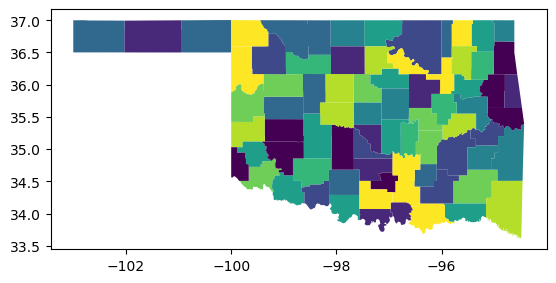

In [22]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]
labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()